In [62]:
%%bash 
pip install scikit-survival

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━38;2;249;38;11m 0.0/3.9 MB ? eta -:--:--4m╸━━━━━━━━━━━━━━━━━━━━━ 1.8/3.9 MB 11.1 MB/s eta 0:00:01━━━━━━━━━━━━━━━━ 3.9/3.9 MB 11.5

In [305]:
# Data loading

import pandas as pd
from pathlib import Path

def load_data(data_dir: Path, file_name="myeloma_data.csv") -> pd.DataFrame:
    """Load dataset from the specified directory."""
    data_file = data_dir / file_name
    return pd.read_csv(data_file)

raw_data = load_data(Path("data"))
raw_data.head()

,ID,Ancestry,PGS_Score,Age,M_Spike,sFLC_Ratio,Creatinine,LP,Time_Months,Status,BMPC_Final,Hgb_Final,PGS_Bin,Clinical_Risk
0,1,European,-0.006056,69.111929,3.282018,3.010026,0.522791,2.172474,16.02,1,25.01001,14.598307,Medium PGS,Int Clinical Risk
1,2,European,0.996723,74.327334,3.468359,3.372553,1.028067,2.034360,0.80,1,NaN,15.478983,Medium PGS,Int Clinical Risk
2,3,European,0.723133,67.378696,0.588324,2.718493,0.775595,0.134618,107.38,0,0.15043,12.717573,Medium PGS,Low Clinical Risk
3,4,European,0.821519,72.769428,1.222824,6.164781,0.943936,2.541208,51.56,1,NaN,NaN,Medium PGS,Low Clinical Risk
4,5,European,-0.806482,64.201009,2.228350,0.438690,0.978404,0.603776,45.18,0,NaN,12.620185,Medium PGS,Int Clinical Risk


In [306]:
import numpy as np

# drop rows with NaN in Status or Time_Months to keep X, y aligned
raw_data = raw_data.dropna(subset=["Status", "Time_Months"])
X = raw_data.drop(columns=["Status", "Time_Months"])
y_event = raw_data["Status"]
y_time = raw_data["Time_Months"]


y_structured = np.array(
    [(bool(e), t) for e, t in zip(y_event, y_time)],
    dtype=[('event', bool), ('time', float)]
)

In [308]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold


scaled_numeric_cols = ["Age", "PGS_Score", "M_Spike", "sFLC_Ratio", "Creatinine", "LP", "BMPC_Final", "Hgb_Final"]
# unscaled_numeric_cols = ["Status"]
categorical_cols = ["Ancestry", "Clinical_Risk"]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num_scaled",
            Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("variance", VarianceThreshold(threshold=1e-5)),  # remove low-variance features
                ("scaler", StandardScaler()),
            ]),
            scaled_numeric_cols
        ),
        # (
        #     "num_raw",
        #     Pipeline([
        #         ("imputer", SimpleImputer(strategy="median")),
        #         ("variance", VarianceThreshold(threshold=1e-5)),  # remove low-variance features
        #     ]),
        #     unscaled_numeric_cols
        # ),
        (
            "cat",
            Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder",
                    OneHotEncoder(
                        handle_unknown="ignore",
                        sparse_output=False,
                        drop="first"
                    ),
                )
            ]),
            categorical_cols
        ),
    ]
)

In [309]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis

models_raw = { }

for alpha in [0.0, 0.1, 0.5, 1.0, 2.0]:
    models_raw[f"CoxPH_{alpha}"] = CoxPHSurvivalAnalysis(alpha=alpha)


for i in range(1, 31):
    models_raw[f"CoxNet_{i}"] = CoxnetSurvivalAnalysis(n_alphas=10*i)

for n_estimators in [50, 100, 150, 200]:
    models_raw[f"RandomSurvivalForest_{n_estimators}"] = RandomSurvivalForest(
        n_estimators=n_estimators, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1
    )
    models_raw[f"GradientBoostingSurvivalAnalysis_{n_estimators}"] = GradientBoostingSurvivalAnalysis(
        learning_rate=1, n_estimators=n_estimators, random_state=1
    )

for i in range(1, 31):
    models_raw[f"ComponentwiseGradientBoostingSurvivalAnalysis_{i}"] = ComponentwiseGradientBoostingSurvivalAnalysis(
        learning_rate=0.1, n_estimators=i*10, random_state=1,
    )

# include data preprocessing to models
models = {
    model_name:
        Pipeline(steps=[
            ("preprocess", preprocessor),
            ("prediction", models_raw[model_name])
        ])
    for model_name in models_raw
}

In [310]:
from sklearn.model_selection import KFold, cross_val_score
from sksurv.metrics import concordance_index_censored

results = {}

for model_name, model in models.items():
    print("---------------------------------")
    print(f"Evaluating model: {model_name}")

    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=1,
    )


    c_indices = cross_val_score(
        model,
        X,
        y_structured,
        cv=cv,
        scoring=lambda est, X, y: concordance_index_censored(
            y["event"],
            y["time"],
            est.predict(X)
        )[0]
    )
    print(f"{model_name}: mean c-index = {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
    print("---------------------------------")
    print()
    results[model_name] = c_indices

---------------------------------
Evaluating model: CoxPH_0.0
CoxPH_0.0: mean c-index = 0.7568 ± 0.0349
---------------------------------

---------------------------------
Evaluating model: CoxPH_0.1
CoxPH_0.1: mean c-index = 0.7568 ± 0.0349
---------------------------------

---------------------------------
Evaluating model: CoxPH_0.5
CoxPH_0.5: mean c-index = 0.7569 ± 0.0350
---------------------------------

---------------------------------
Evaluating model: CoxPH_1.0
CoxPH_1.0: mean c-index = 0.7568 ± 0.0352
---------------------------------

---------------------------------
Evaluating model: CoxPH_2.0
CoxPH_2.0: mean c-index = 0.7569 ± 0.0353
---------------------------------

---------------------------------
Evaluating model: CoxNet_1
CoxNet_1: mean c-index = 0.7569 ± 0.0349
---------------------------------

---------------------------------
Evaluating model: CoxNet_2
CoxNet_2: mean c-index = 0.7571 ± 0.0349
---------------------------------

-------------------------------

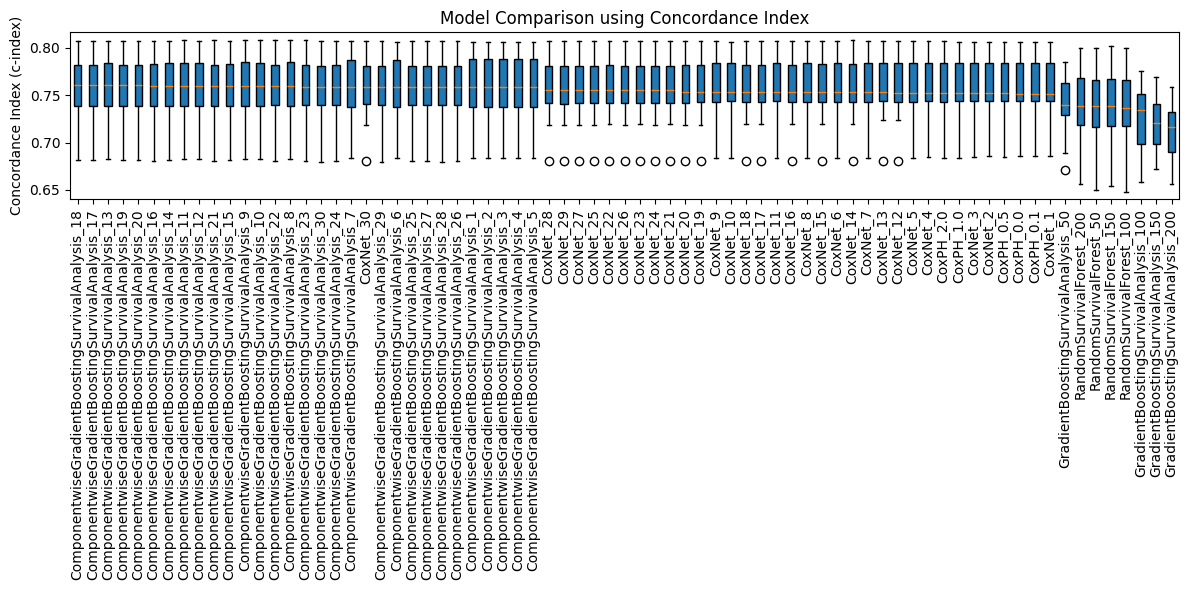

In [ ]:
# results = sorted(results.items(), key=lambda x: x[1].mean())
# compare the models
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))

# sort models by mean c-index for a clearer comparison
sorted_items = sorted(results.items(), key=lambda kv: np.median(kv[1]), reverse=True)
labels = [k for k, _ in sorted_items]
data = [v for _, v in sorted_items]

ax.boxplot(data, vert=True, patch_artist=True)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Concordance Index (c-index)")
ax.set_title("Model Comparison using Concordance Index")
plt.tight_layout()
plt.show()

Predicted probabilities for the example data: [StepFunction(x=array([1.0000e-01, 1.1000e-01, 2.7000e-01, ..., 1.1983e+02, 1.1995e+02,
        1.2000e+02], shape=(1577,)), y=array([3.00964216e-04, 6.02804030e-04, 9.04715412e-04, ...,
        3.84384663e-01, 3.84384663e-01, 3.84384663e-01], shape=(1577,)), a=np.float64(10.106843787064538), b=0.0)]


IndexError: index 1 is out of bounds for axis 0 with size 1

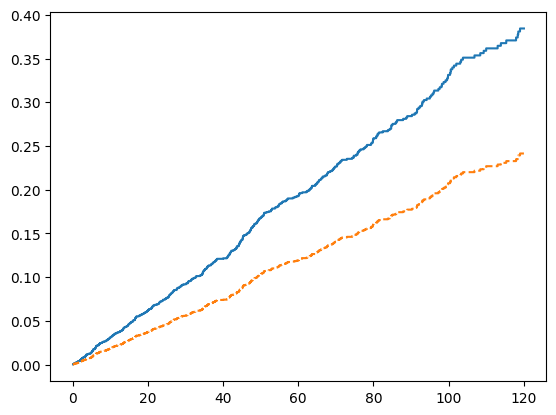

In [317]:
# now fit the model on the entire dataset
X_preprocessed = preprocessor.fit_transform(X)
models_raw["ComponentwiseGradientBoostingSurvivalAnalysis_13"].fit(X_preprocessed, y_structured)
models_raw["CoxPH_2.0"].fit(X_preprocessed, y_structured)

# see some inference examples
example_data = pd.DataFrame([
    {
        "Age": 65,
        "PGS_Score": 1.2,
        "M_Spike": 15.0,
        "sFLC_Ratio": 45.8,
        "Creatinine": 0.5,
        "LP": 2,
        "Time_Months": 5,
        "BMPC_Final": 15,
        "Hgb_Final": 13.5,
        "Ancestry": "European",
        "Clinical_Risk": "Low Clinical Risk"
    },
])

example_data_preprocessed = preprocessor.transform(example_data)
hazard_function = models_raw["ComponentwiseGradientBoostingSurvivalAnalysis_13"].predict_cumulative_hazard_function(example_data_preprocessed)
hazard_function2 = models_raw["CoxPH_2.0"].predict_cumulative_hazard_function(example_data_preprocessed)
print(f"Predicted probabilities for the example data: {hazard_function}")

# plot the hazard function
import matplotlib.pyplot as plt
for i in range(200):
    plt.step(hazard_function[i].x, hazard_function[i].y, where="post")
    plt.step(hazard_function2[i].x, hazard_function2[i].y, where="post", linestyle="--")
plt.xlabel("Time in months")
plt.ylabel("Cumulative hazard")
plt.title("Predicted Cumulative Hazard Function")
plt.show()


In [316]:
hazard_function.shape

(1,)